# Exploratory Data Analysis of Movie Datasets

## Introduction

As a data scientist,I have been tasked by **Microsoft** to conduct an **exploratory data analysis** (EDA) to generate insights on the movie industry. The project involves analyzing *six movie datasets* to provide insights and recommendations.

<img src="image.jpeg" width="800" height="400">

# Business Understanding

 Microsoft have decided to create a new movie studio. Unfortunately, they have limited knowledge about creating movies. They need to gain understanding into the movie industry, such as the relationships between production budgets, revenues, ratings, genres and other key factors that contribute to the success of a movie.
 
 The goal of this project is to help Microsoft make data-driven decisions that will give them and opportunity to succeed in the highly competitive movie production industry.

## Data Understanding

### IMDb

The IMDb database is a comprehensive database containing information on movies content. It contains data on numerous titles and is organized into 8 tables;
- `persons`
- `writers`
- `directors`
- `known_for`
- `principals`
- `movie_basics`
- `movie_rating` 
- `movie_akas`

Below is the database's Entity Relationship Diagram 

<img src="movie_data_erd.jpeg" width="800" height="600">

# 1. What insights can we get using the genres in the movie industry?

Possible genre analysis
- Genres frequency distribution
- Number of votes per genre
- Average rate per genre

IMDb database can be used to analyse the most popular genres in the movie industry and generate a frequency distribution of genres across all movies in the `movie_basics` table.
To understand the number of votes and average rate for each genre, we'll include the `movie_ratings`.
 

## Data Understanding

Each record in the `movie_basics` and `movie_ratings` represents a single movie. There are approximately 146,000 and 74,000 movie records in the respective table.

The columns from `movie_basics` table provides 6 basic information about each movie:
- `movie_id`
- `primary_title`
- `original_title`
- `start_year`
- `runtime_minutes`
- `genres`

Features in `movie_ratings`:
- `movie_id`
- `averagerating`
- `numvotes`

However our focus will be on `movie_id` feature which represents their ID, `genres` column which contains the genre or genres of the movie, separated by vertical bar (`|`), `average_id` which gives the average ratings per movie, and finally `numvotes` which represents number of votes per genre.

## Requirements

- load dataset
- Perform Data Cleaning Required
- Data Aggregation
- Visualization
- Answer the question



Loading the necessary libraries, `pandas`, `numpy`, `sqlite3` and `seaborn`


In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Establishing a connection to the database `Data/im.db`, called `conn`

In [2]:
conn = sqlite3.connect('Data/im.db')

Viewing the table names

In [3]:
q = """
SELECT name
FROM sqlite_master
WHERE type = 'table'
"""
pd.read_sql(q, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


Getting the required columns from the tables and call DataFrame `rate_genre`

In [98]:
q = """
SELECT movie_id,
       genres,
       averagerating,
       numvotes,
       runtime_minutes
FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
"""
genre_df = pd.read_sql(q, conn)
# Overview of the data
print(genre_df.info())
# Viewing the first 5 rows
genre_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   genres           73052 non-null  object 
 2   averagerating    73856 non-null  float64
 3   numvotes         73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.8+ MB
None


,movie_id,genres,averagerating,numvotes,runtime_minutes
0,tt0063540,"Action,Crime,Drama",7.0,77,175.0
1,tt0066787,"Biography,Drama",7.2,43,114.0
2,tt0069049,Drama,6.9,4517,122.0
3,tt0069204,"Comedy,Drama",6.1,13,NaN
4,tt0100275,"Comedy,Drama,Fantasy",6.5,119,80.0


In [101]:
genre_df.runtime_minutes.isna().sum()

7620

#### **Data Cleaning**

Checking for **missing values**

In [109]:
def identifying_missing_values(data):
    """Identify if the data has missing values"""
    # identify if data has missing values(data.isnull().any())
    # empty dict to store missing values
    missing = []
    for i in data.isnull().any():
        # add the bool values to empty list 
        missing.append(i)
    # covert list to set (if data has missing value, the list should have true and false)
    missing_set = set(missing)
    if (len(missing_set) == 1):
        out = print("The Data has no missing values")
    else:
        out = print("The Data has missing values.")

    return out

def missing_values(data):
    """A simple function to identify data has missing values"""
    # identify the total missing values per column
    # sort in order 
    miss = data.isnull().sum().sort_values(ascending = False)

    # calculate percentage of the missing values
    percentage_miss = (data.isnull().sum() / len(data)).sort_values(ascending = False)

    # store in a dataframe 
    missing = pd.DataFrame({"Missing Values": miss, "Percentage": percentage_miss})

    # remove values that are missing 
    missing.drop(missing[missing["Percentage"] == 0].index, inplace = True)

    return missing

In [103]:

identifying_missing_values(genre_df)

The Data has missing values.


In [110]:
missing_data = missing_values(genre_df)
missing_data

,Missing Values,Percentage
runtime_minutes,7620,0.103174
genres,804,0.010886


The `genres` column has 804 missing values which make up only 1% of the dataset. **Dropping the rows** is a safe choice here since our analysis is entirely based on the genres and replacing them with the most frequent value may alter our output accuracy

In [8]:
genre_df.dropna(inplace=True)
identifying_missing_values(genre_df)

The Data has no missing values


Proceeding to check for **duplicates**

In [111]:
def identify_duplicates(data):
    """Simple function to identify any duplicates"""
    # identify the duplicates (dataframename.duplicated() , can add .sum() to get total count)
    # empty list to store Bool results from duplicated
    duplicates = []
    for i in data.duplicated():
        duplicates.append(i)
    # identify if there is any duplicates. (If there is any we expect a True value in the list duplicates)
    duplicates_set = set(duplicates) 
    if (len(duplicates_set) == 1):
        print("The Data has no duplicates")
    else:
        no_true = 0
        for val in duplicates:
            if (val == True):
                no_true += 1
        # percentage of the data represented by duplicates 
        duplicates_percentage = np.round(((no_true / len(data)) * 100), 3)
        print(f"The Data has {no_true} duplicated rows.\nThis constitutes {duplicates_percentage}% of the data set.") 



identify_duplicates(genre_df)

The Data has no duplicates


Inspect the column **data types**

In [112]:
genre_df.dtypes

movie_id            object
genres              object
averagerating      float64
numvotes             int64
runtime_minutes    float64
dtype: object

Checking for **numeric column distribution** to detect placeholders

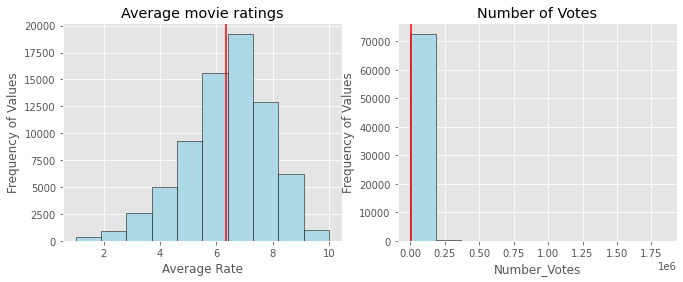

In [11]:
plt.style.use('ggplot') #grid view on plot
# Create the plot
fig, (ax1, ax2) = plt.subplots(figsize = (11, 4), ncols = 2)

# Plot `avaragerating` bar plot
ax1.hist(genre_df.averagerating, edgecolor = 'black', color = 'lightblue')
# Adding a vertical line which represent the mean
ax1.axvline(np.mean(genre_df.averagerating), color = 'red', label = 'Average of averagerating')
# Set x and y axes lables and the title
ax1.set_xlabel('Average Rate')
ax1.set_ylabel('Frequency of Values')
ax1.set_title('Average movie ratings')

# Plot `numvotes` bar plot
ax2.hist(genre_df.numvotes, bins = 10, edgecolor = 'black', color = 'lightblue')
# Adding a vertical line which represent the mean
ax2.axvline(np.mean(genre_df.numvotes), color = 'red', label = 'Average of number of votes')
# Set x and y axes lables and the title
ax2.set_xlabel('Number_Votes')
ax2.set_ylabel('Frequency of Values')
ax2.set_title('Number of Votes');

***Interpretation of the average rating distribution***

In [12]:
print(f'The mean of the average movie ratings is: {round(np.mean(genre_df.averagerating), 2)} ')
print(f'The median of the average movie ratings is: {round(np.median(genre_df.averagerating), 2)} ')
print(f'The standard deviation of the average movie ratings is: {round(np.std(genre_df.averagerating), 2)}')

The mean of the average movie ratings is: 6.33 
The median of the average movie ratings is: 6.5 
The standard deviation of the average movie ratings is: 1.47


- The mean of the average movie ratings is `6.33`, which suggests that, on average, the movies are rated slightly above average.  The median of the average movie ratings is `6.5`, which means that half of the movies have a rating higher than 6.5 and half have a rating lower than 6.5. This measure of central tendency is less sensitive to extreme values than the mean and can be a more accurate representation of the "typical" rating.
- The **difference** between the mean and the median is relatively small `(0.17)`, which might suggest that the distribution is approximately symmetric, with a relatively small amount of negative skewness
- The standard deviation `(1.47)` indicates that there is some variability in the ratings. A larger standard deviation would suggest that the ratings are more spread out, while a smaller standard deviation would suggest that the ratings are more tightly clustered around the mean.

***Interpretation of the number of votes distribution***

In [13]:
print(f'The mean of the number of votes is: {round(np.mean(genre_df.numvotes), 2)} ')
print(f'The median of the number of votes is: {np.median(genre_df.numvotes)} ')
print(f'The standard deviation of the number of votes is: {round(np.std(genre_df.numvotes), 2)}')
print(f'The minimum number of votes is: {np.min(genre_df.numvotes)}')
print(f'The maximum number of votes is: {np.max(genre_df.numvotes)}')

The mean of the number of votes is: 3562.17 
The median of the number of votes is: 50.0 
The standard deviation of the number of votes is: 30457.83
The minimum number of votes is: 5
The maximum number of votes is: 1841066


- This distribution of the number of votes per movie suggests that the dataset is **highly positively skewed**, with a small number of movies receiving a large number of votes, while most movies receive only a few votes. The median of only 50 votes indicates that half of the movies in the dataset received fewer than 50 votes, while the *mean value is heavily influenced by the small proportion of movies with a large number of votes*.
- The high standard deviation suggests that the data is spread out over a wide range, with many outliers. The minimum value of 5 votes is quite low, indicating that there are many movies in the dataset that received very few votes. The maximum value of 1,841,066 votes is **much larger** than the mean or median, indicating that there are a few movies in the dataset that are **exceptionally popular**.
- The resulting skewness and outliers maybe be due to a combination of factors, including the popularity of certain movies, differences in release dates and marketing efforts, and the influence of user-generated content platforms, which may amplify the popularity of some movies while suppressing others.

(More analysis on the number of votes to be done)

**Categorical data** structural information

Everything looks okay so far to continue with genre analysis.

However, The `genres` column needs more attention. Some of the entries represents more than one genres.

In [14]:
# Investigating the number of unique genres
print(f"The current number of unique genres is: {genre_df.genres.nunique()}")

The current number of unique genres is: 923


In [15]:
# Display the first 5 rows
genre_df.head()

,movie_id,genres,averagerating,numvotes
0,tt0063540,"Action,Crime,Drama",7.0,77
1,tt0066787,"Biography,Drama",7.2,43
2,tt0069049,Drama,6.9,4517
3,tt0069204,"Comedy,Drama",6.1,13
4,tt0100275,"Comedy,Drama,Fantasy",6.5,119



Using `rate_genre.explode()`

In [114]:
genre_df['genres'] = genre_df['genres'].str.split(',')
genre_df = genre_df.explode('genres')
genre_df.head(10)

,movie_id,genres,averagerating,numvotes,runtime_minutes
0,tt0063540,Action,7.0,77,175.0
0,tt0063540,Crime,7.0,77,175.0
0,tt0063540,Drama,7.0,77,175.0
1,tt0066787,Biography,7.2,43,114.0
1,tt0066787,Drama,7.2,43,114.0
2,tt0069049,Drama,6.9,4517,122.0
3,tt0069204,Comedy,6.1,13,NaN
3,tt0069204,Drama,6.1,13,NaN
4,tt0100275,Comedy,6.5,119,80.0
4,tt0100275,Drama,6.5,119,80.0


In [17]:
# Checking the new number of unique genres
print(f"The number of unique genres is now: {genre_df.genres.nunique()}")

The number of unique genres is now: 26


In [18]:
# Top 5 genres
genre_df.genres.value_counts()[:5]

Drama          30788
Documentary    17753
Comedy         17290
Thriller        8217
Horror          7674
Name: genres, dtype: int64

### **Data Exploration and visualization**

#### Genre distribution

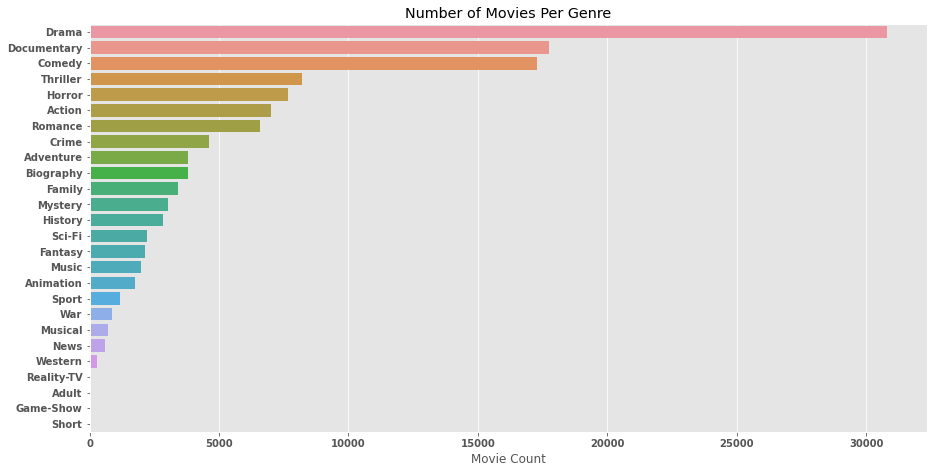

In [82]:
# Set up plot
fig, ax = plt.subplots(figsize=(15,7.5))
sns.countplot(data=genre_df, y='genres', order = genre_df['genres'].value_counts().index)
plt.xticks(fontsize =10, fontweight = 'bold')
plt.yticks(fontsize =10, fontweight = 'bold')
plt.xlabel('Movie Count' )
plt.ylabel('')
plt.title('Number of Movies Per Genre');


(conclusions from the plots)

#### Votes per Genre

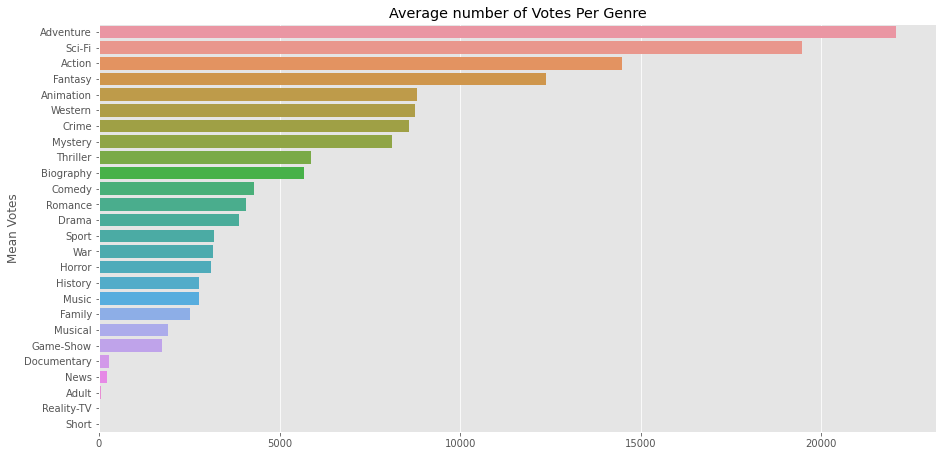

In [96]:
genre_votes = genre_df.groupby('genres')['numvotes'].mean().sort_values(ascending=False)
# Set up plot
fig, ax = plt.subplots(figsize=(15,7.5))
sns.barplot(y=genre_votes.index, x= genre_votes.values)
# plt.xticks(range(len(genre_votes)), genre_votes.index, rotation = -45 )
ax.set_ylabel('Mean Votes')
ax.set_title('Average number of Votes Per Genre');

palettepalette name, list, or dict
Colors to use for the different levels of the hue variable. Should be something that can be interpreted by color_palette(), or a dictionary mapping hue levels to matplotlib colors.

<AxesSubplot: ylabel='genres'>

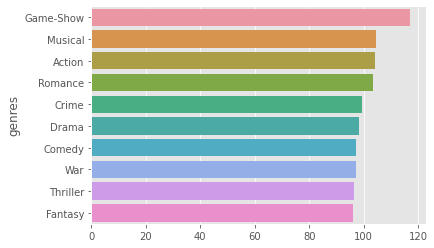

In [142]:
runtime = genre_df.groupby('genres')['runtime_minutes'].mean().sort_values(ascending=False)[:10]
runtime

# sns.color_palette("mako", as_cmap=True)
sns.barplot(x = runtime.values, y = runtime.index)

(Conclusions)

#### Rate per Genre

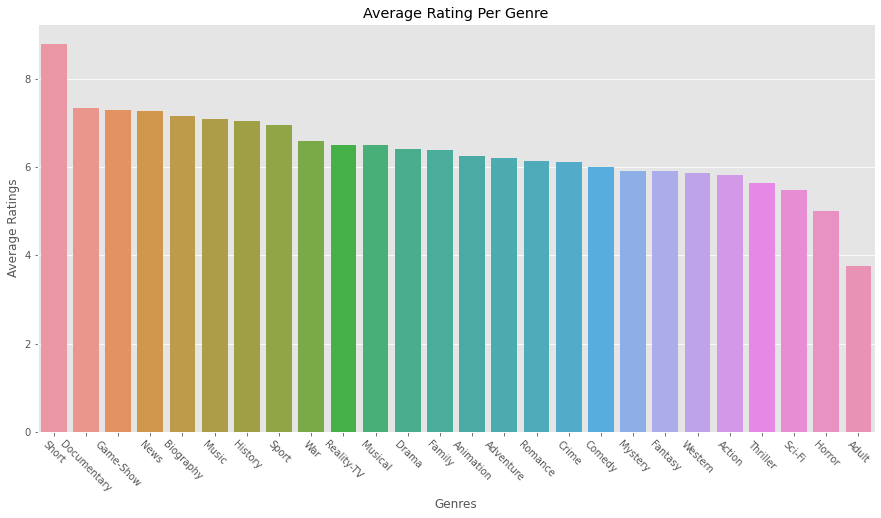

In [21]:
genre_rates = genre_df.groupby('genres')['averagerating'].mean().sort_values(ascending=False)
# Set up plot

sns.barplot(data=genre_rates, x=genre_rates.index, y = genre_rates.values, order=genre_rates.values)
plt.xticks(range(len(genre_rates)), genre_rates.index, rotation = -45 )
ax.set_xlabel('Genres')
ax.set_ylabel('Average Ratings')
ax.set_title('Average Rating Per Genre');

Final interpretations and conclusions

# Budget and Gross

In [23]:
# Load the dataset
df1 = pd.read_csv('Data/tn.movie_budgets.csv')
# Overview info of the dataset
print(df1.info())
# Preview first 5 rows
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
None


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


Data cleaning

In [24]:
# Inspect columns data types
df1.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

Converting `realease_date` into datetime format

In [25]:
df1['release_date'] = pd.to_datetime(df1['release_date'])

`production_budget`, `domestic_gross`, `worldwide_gross` to int64 data type

In [26]:
def convert_price_to_int64(df, column_name):
    # Remove commas and dollar signs from the column
    df[column_name] = df[column_name].str.replace(',', '', regex=False).str.replace('$', '', regex=False)
    # Convert to int64
    df[column_name] = df[column_name].astype('int64')
    return df

convert_price_to_int64(df1, 'production_budget')
convert_price_to_int64(df1, 'domestic_gross')
convert_price_to_int64(df1, 'worldwide_gross')

df1.dtypes

id                            int64
release_date         datetime64[ns]
movie                        object
production_budget             int64
domestic_gross                int64
worldwide_gross               int64
dtype: object

In [27]:
# identify missing values
identifying_missing_values(df1)

The Data has no missing values


In [28]:
# check for number of rows with zero values
zero_values = df1.query('production_budget == 0 | domestic_gross == 0 | worldwide_gross == 0')
print(f'There are {len(zero_values)} rows with zero values.\nThis amounts to {round(len(zero_values)/len(df1)*100, 2)}% of the original dataset.')

There are 548 rows with zero values.
This amounts to 9.48% of the original dataset.


In [29]:
# drop rows with zero values in the 'production_budget', 'domestic_gross', and 'worldwide_gross' columns
df1 = df1.loc[(df1['production_budget'] != 0) & (df1['domestic_gross'] != 0) & (df1['worldwide_gross'] != 0)]

In [30]:
# check duplicated rows
identify_duplicates(df1)

The Data has no duplicates


In [31]:
# identify duplicated values in `movie` column
print(f" `movie` column has {df1['movie'].duplicated().sum()} duplicated values")

 `movie` column has 75 duplicated values


In [32]:
# keep the first row of the `movie`column duplicate
df1.drop_duplicates(subset='movie', keep='first', inplace=True)
df1['movie'].duplicated().sum()

0

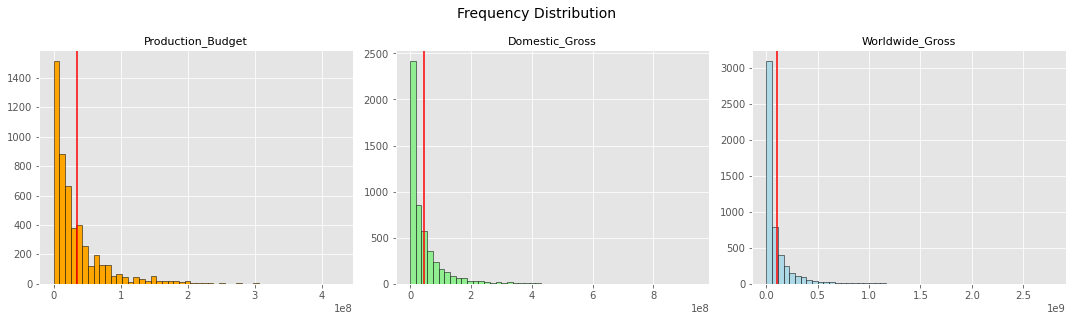

In [33]:
# create a figure with three subplots
fig, axes = plt.subplots(ncols=3, figsize=(15,4.5))

color_list = ['lightblue', 'pink', 'gray', 'gold', 'orange', 'lightgreen', 'cyan']
np.random.seed(00)
# plot a histogram for each column in the dataset
for i, ax in enumerate(axes):
    col_name = df1.columns[i+3]
    data = df1.loc[:, col_name]
    ax.hist(data, bins=50, edgecolor='black', color=np.random.choice(color_list))
    ax.axvline(data.mean(), color='red')
    ax.set_title(col_name.title(), fontsize=11)

# set the title for the entire figure
fig.suptitle('Frequency Distribution', fontsize=14)

# adjust the spacing between subplots
fig.tight_layout()

# show the plot
plt.show()


Data exploration and visualization

##### Did the movies with the highest budget generate the highest revenue?

**Correlation between `production_budget` and gross**

In [34]:
# correlation coefficients between production budget and revenue
corr_domestic = np.corrcoef(df1['production_budget'], df1['domestic_gross'])[0,1]
corr_worldwide = np.corrcoef(df1['production_budget'], df1['worldwide_gross'])[0,1]
# Print the correlation coefficients
print('Correlation between production budget and domestic gross:', corr_domestic.round(2))
print('Correlation between production budget and worldwide gross:', corr_worldwide.round(2))

Correlation between production budget and domestic gross: 0.68
Correlation between production budget and worldwide gross: 0.75


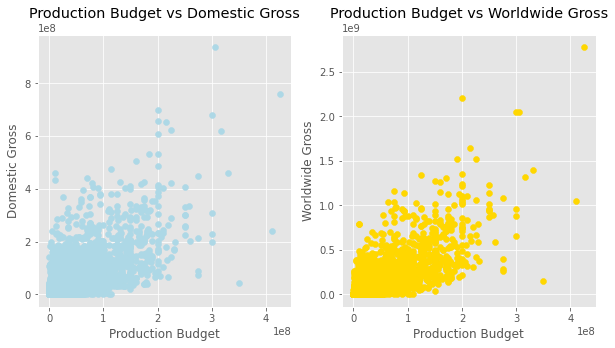

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(df1['production_budget'], df1['domestic_gross'], color = 'lightblue')
axs[0].set_xlabel('Production Budget')
axs[0].set_ylabel('Domestic Gross')
axs[0].set_title('Production Budget vs Domestic Gross')

axs[1].scatter(df1['production_budget'], df1['worldwide_gross'], color = 'gold')
axs[1].set_xlabel('Production Budget')
axs[1].set_ylabel('Worldwide Gross')
axs[1].set_title('Production Budget vs Worldwide Gross')
plt.show()

The above correlation coefficients and the scatter plot indicate a ***moderately strong positive correlation*** between the production budget and both measures of gross.  This analysis argues that **movies with a higher production budget tend to earn more revenue.**

My recommendation for Microsoft would be to consider increasing their production budget, as this could potentially result in higher revenue for their movies


#### Is there a seaonality trend

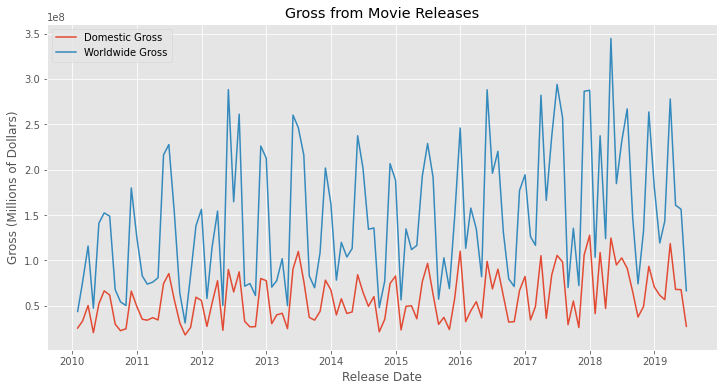

In [77]:
# filter the dataset to only include movies released in the last 10 years to avoid using outdated data for analysis
new_df = df1[df1['release_date'].dt.year >= 2010]

# group the dataset by months of release date and calculate the mean revenue for each month
monthly_revenue = new_df.groupby(pd.Grouper(key='release_date', freq='M'))[['domestic_gross', 'worldwide_gross']].mean()

# create a time series graph of the monthly revenue
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_revenue.index, monthly_revenue['domestic_gross'], label='Domestic Gross')
ax.plot(monthly_revenue.index, monthly_revenue['worldwide_gross'], label='Worldwide Gross')
ax.set_xlabel('Release Date')
ax.set_ylabel('Gross (Millions of Dollars)')
ax.set_title('Gross from Movie Releases')
ax.legend()

plt.show()

Based on the trend in the time series plot, it appears that the revenue for movies tends to be **higher during the mid months of the year**, which could correspond to the **summer period of the northern hemisphere**. This is a common trend in the movie industry, as many people tend to have more free time during the summer months and are more likely to go to the movies.

Therefore, I would recommend that Microsoft consider releasing their movies during the mid months of the year, particularly in the summer months. This could increase the chances of their movies being successful and generating higher revenue.

Moreover, by **comparing the domestic and worldwide gross**, it is evident that **movies performed well in a global market**. This could indicate that the most movies had a broad appeal that could be successful in multiple regions.

Based on this analysis, to maximize revenue, it may be beneficial for Microsoft to **create movies with broad internation appeal**. This could involve incorporating elements that are **polular across different cultures and languages** as well as **targeting marketing efforts towards international audiences**.

In [73]:
yearly_budget = df1.groupby('release_date')['production_budget'].mean()
yearly_budget

release_date
1920-09-17    1.000000e+05
1925-11-19    2.450000e+05
1925-12-30    3.900000e+06
1929-02-01    3.790000e+05
1931-12-26    5.580000e+05
                  ...     
2019-05-17    2.450000e+07
2019-05-24    9.450000e+07
2019-05-31    7.200000e+07
2019-06-07    1.446667e+08
2019-06-14    1.100000e+08
Name: production_budget, Length: 2178, dtype: float64

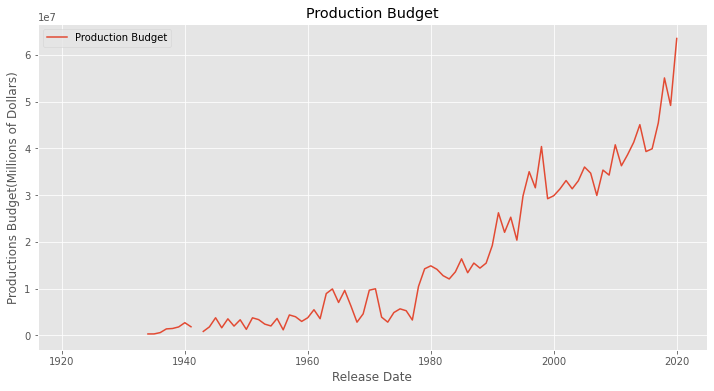

In [75]:
# filter the dataset to only include movies released in the last 10 years to avoid using outdated data for analysis
new_df = df1[df1['release_date'].dt.year >= 1920]

# group the dataset by months of release date and calculate the mean revenue for each month
yearly_budget = new_df.groupby(pd.Grouper(key='release_date', freq='Y'))['production_budget'].mean()

# create a time series graph of the yearly budget
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(yearly_budget.index, yearly_budget.values, label='Production Budget')
ax.set_xlabel('Release Date')
ax.set_ylabel('Productions Budget(Millions of Dollars)')
ax.set_title('Production Budget')
ax.legend()

plt.show()

In [ ]:
q = """
SELECT 
"""

# Directors, Writers 

In [37]:
q = """
SELECT movie_id,
       m.primary_title AS movie,
       d.person_id AS director,
       p.primary_name AS director_name,
       r.averagerating
FROM persons AS p
JOIN directors AS d
    USING(person_id)
 JOIN movie_basics AS m
    USING(movie_id)
 JOIN movie_ratings AS r
    USING(movie_id)

GROUP BY movie_id
"""
directors = pd.read_sql(q, conn)

In [38]:
q = """
SELECT movie_id,
       w.person_id AS writer,
       p.primary_name AS writer_name     
FROM persons AS p
JOIN writers AS w
    USING(person_id)

GROUP BY movie_id
"""
writers = pd.read_sql(q, conn)

In [39]:
# merge directors and writers df
df2 = directors.merge(writers, on="movie_id", how="inner")

# drop unnecessary columns
df2.drop(columns=['director', 'writer'], inplace=True)

# rearange the columns
cols = df2.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[-2:-1]
df2 = df2[cols]

In [42]:
# overview information on the dataset
print(df2.info())
# preview the dataset
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63087 entries, 0 to 63086
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       63087 non-null  object 
 1   movie          63087 non-null  object 
 2   director_name  63087 non-null  object 
 3   writer_name    63087 non-null  object 
 4   averagerating  63087 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.9+ MB
None


,movie_id,movie,director_name,writer_name,averagerating
0,tt0063540,Sunghursh,Harnam Singh Rawail,Gulzar,7.0
1,tt0069049,The Other Side of the Wind,Orson Welles,Oja Kodar,6.9
2,tt0069204,Sabse Bada Sukh,Hrishikesh Mukherjee,Gulzar,6.1
3,tt0100275,The Wandering Soap Opera,Raoul Ruiz,Raoul Ruiz,6.5
4,tt0137204,Joe Finds Grace,Anthony Harrison,Anthony Harrison,8.1


Data Cleaning

In [43]:
# check missing values
identifying_missing_values(df2)

The Data has no missing values


In [44]:
# check duplicated rows
identify_duplicates(df2)

The Data has no duplicates


In [47]:
# identify duplicated values in `movie_id` column
print(f" `movie_id` column has {df2['movie_id'].duplicated().sum()} duplicated values")

 `movie_id` column has 0 duplicated values


The dataset is ready for analysis

In [78]:
df2.groupby('director_name') ['averagerating'].mean().sort_values(ascending=False).iloc[:10]

director_name
Taylor Morden               10.0
Cristina Duarte             10.0
Ivana Diniz                 10.0
Emre Oran                   10.0
Loreto Di Cesare            10.0
Lindsay Thompson            10.0
Dante Tanikie-Montagnani     9.8
Bonnie Hawthorne             9.8
David Sipos                  9.8
Javi Larrauri                9.8
Name: averagerating, dtype: float64